# Set-Up: Installing system dependencies, setting data paths
Modules used:
tensorflow
opencv-python
matplotlib
os
This Notebook primarily relies on https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte as a tutorial

In [41]:
# be able to take input from a server (sent from mobile device) or from the camera sensor.

In [42]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [43]:
import tensorflow as tf
import os

In [44]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [45]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [46]:
# importing dependencies
import cv2
from matplotlib import pyplot as plt
import imghdr # TO DO : replace with a non-deprecated library

In [47]:
# Set the data directory
data_dir = 'data'

In [48]:
# telling the computer what the image extensions are
image_exts = ['jpeg', 'jpg', 'bmp', 'png'] 

In [49]:
os.listdir(data_dir) # should return benign and malignant ; 
# returns folders inside of the data dir

['.DS_Store', 'test', 'malignant', 'benign']

In [50]:
# os.listdir(os.path.join(data_dir, 'malignant'))
# os.listdir(os.path.join(data_dir, 'benign'))
# returns every image within the folder

In [51]:
for image_class in os.listdir(data_dir):
    print(image_class) # loops thru directories

.DS_Store
test
malignant
benign


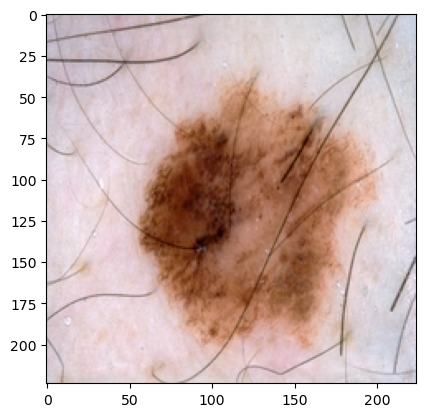

In [52]:
img = cv2.imread(os.path.join('data', 'malignant', '267.jpg'))
# type(img) numpy array
# img.shape # 3 means is is a colored image long x high
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # this will display img

In [53]:
for image_class in os.listdir(data_dir):
    if image_class != '.DS_Store':
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                img = cv2.imread(image_path) # opens image
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print("image contains an unknown extension: {}".format(image_path))
                    os.remove(image_path) # deletes files from the dir if they r weird
            except Exception as e:
                print('uh oh! issue with image : {}'.format(image_path))

## Load in images using Keras

In [54]:
tf.data.Dataset # allows us to build data pipelines
# uses Keras utility

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [55]:
import numpy as np

In [56]:
data = tf.keras.utils.image_dataset_from_directory('data')
# builds image data set and performs preprocessing

Found 3297 files belonging to 3 classes.


In [57]:
# note that data is a generator; convert 
# it into a numpy iterator.
data_iterator = data.as_numpy_iterator()

In [58]:
# grabbing one batch/accessing it
batch = data_iterator.next()

In [59]:
len(batch)
# 2 parts to this data set, 
#images and labels

2

In [60]:
batch[0].shape
# images are represented as numpy array
# 32:
# 256:
# 256: 
# 3:

(32, 256, 256, 3)

In [61]:
batch[1] 

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

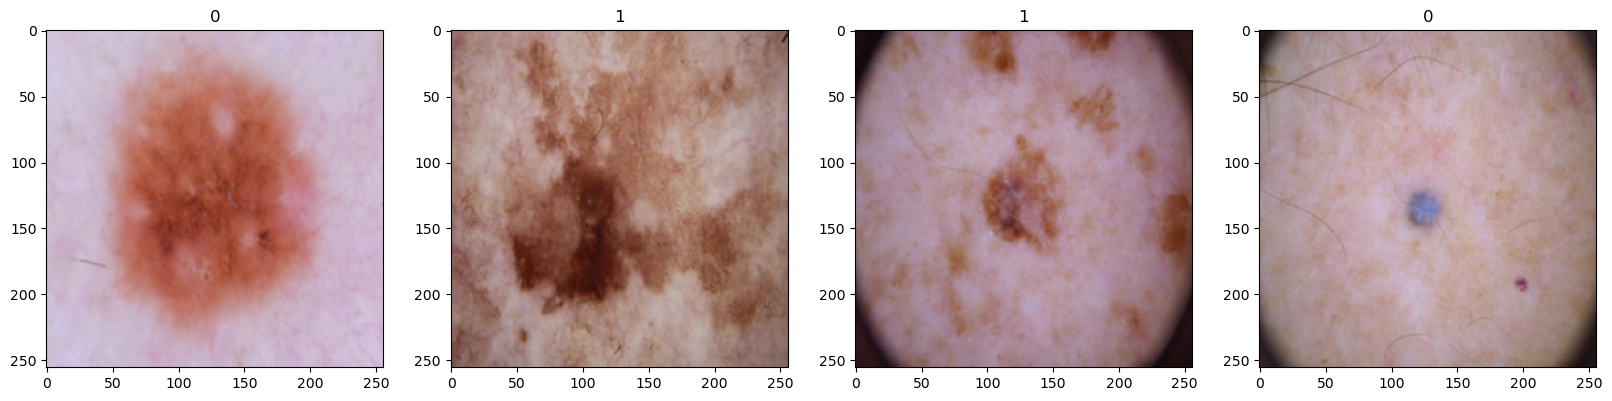

In [62]:
batch = data_iterator.next()
# check if 0 and 1 is benign or malignant
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# result: 1 is flag for malignant
# result: 0 is flag for benign

# Pre-processing the data

In [63]:
scaled = batch[0]

In [64]:
data = data.map(lambda x,y: (x/255,y))

In [65]:
scaled_iterator = data.as_numpy_iterator()

In [66]:
batch = scaled_iterator.next()

In [67]:
# scaled_iterator = data.as_numpy_iterator() # make sure you have shuffling for this

In [68]:
# scaled_iterator.next()[0].max()

In [69]:
# splitting data
# estab. training data sizes
len(data) # 104 batches

104

In [70]:
train_size = int(len(data) *.8)
val_size = int(len(data)*.1)
test_size = int(len(data) * .1)

In [71]:
test_size + val_size + train_size

103

In [72]:
# using the take and skip methods in tensorflow pipeline
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [73]:
len(test)

10

# Modelling with Keras Sequential API and Building the Deep Learning Model

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [75]:
model = Sequential() # Instantiating the model

## Convolution Block
We have a total of 3 convolution blocks that are flattened.
* model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
    * **Conv2D function**
        * First argument (16) specifies the number of filters.
        * Second argument ((3,3)) specifies the shape of the filters.
        * The argument activation specifies which activation we want to use. Here, we use relu activation because
        * Input shape takes a 30tuple that specifies our images are 256 x 256 by 3 channels deep.
    * We will take all the output from a layer and pass it to a function to model what the data looks like. It changes and reshapes what the output looks like.
    * We will have 16 filters of shape 3 * 3.
Pooling blocks
Dense layers (fully connected layers)

## Flattening the layers

In [76]:
model.add(Conv2D(16, (3,3), 1,
                 activation = 'relu',
                 input_shape = (256,256,3)
                 )
          )
# 16 filters of shape 3 x 3
# images are going to be 256 x 256 by 3 channels deep
model.add(MaxPooling2D()) # takes the max val after the relu activation and condenses the info

# convolution block
model.add(Conv2D(32, (3,3), 1, 
                 activation='relu')
         )
model.add(MaxPooling2D())

# convolution block
model.add(Conv2D(16, (3,3), 1, 
                 activation='relu')
         )
model.add(MaxPooling2D())

# Flattening the data after condensing the rows and width
# # of filters will form the channel value, flattening it will
# give u one value as output
model.add(Flatten())

# Dense layers (fully connected layers)
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
# sigmoid activation converts it into either 0 or 1
# 0 or 1 maps to either of our classes

In [77]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [78]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [122]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [123]:
from keras.callbacks import EarlyStopping

In [124]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 3)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [126]:
hist = model.fit(train, epochs=15, validation_data = val, callbacks = [es])

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 796ms/step - accuracy: 0.9002 - loss: 0.2201 - val_accuracy: 0.8656 - val_loss: 0.3168
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 675ms/step - accuracy: 0.9260 - loss: 0.1951 - val_accuracy: 0.8469 - val_loss: 0.3318
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 697ms/step - accuracy: 0.9337 - loss: 0.1854 - val_accuracy: 0.8469 - val_loss: 0.3763
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 0.9327 - loss: 0.1821 - val_accuracy: 0.8281 - val_loss: 0.3692


In [127]:
hist.history

{'accuracy': [0.9047439694404602,
  0.9220632314682007,
  0.9344879388809204,
  0.9322289228439331],
 'loss': [0.2036641538143158,
  0.1928398609161377,
  0.16702011227607727,
  0.16798774898052216],
 'val_accuracy': [0.8656250238418579,
  0.846875011920929,
  0.846875011920929,
  0.828125],
 'val_loss': [0.31677407026290894,
  0.3318411707878113,
  0.37626343965530396,
  0.3691788613796234]}

## Plotting out performance with Matplotlib

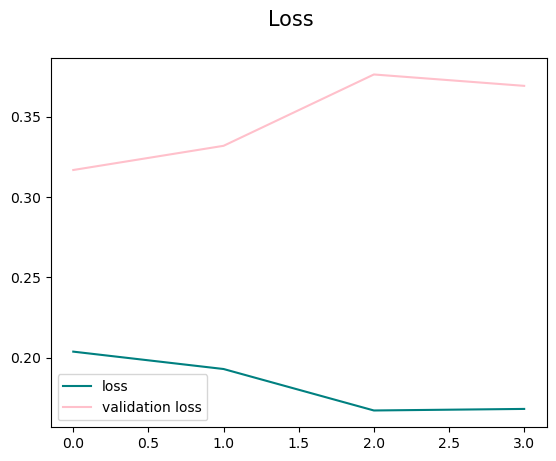

In [128]:
fig = plt.figure()
plt.plot(hist.history['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(hist.history['val_loss'], 
         color = 'pink', 
         label = 'validation loss')
fig.suptitle('Loss', fontsize = 15)
plt.legend(loc = "lower left")
plt.show()
# plt.savefig("")

## Testing the Model - Evaluating Performance

In [129]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [130]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
# change variable names

In [131]:
len(test)

10

In [132]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2024-10-24 20:16:01.047357: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [133]:
print(f'Precision:{pre.result().numpy()},' +
      f'Recall:{re.result().numpy()}, ' +
      f'Accuracy:{acc.result().numpy()}')

Precision:0.8981481194496155,Recall:0.7028985619544983, Accuracy:0.8374999761581421


## Testing with original input

In [134]:
import cv2

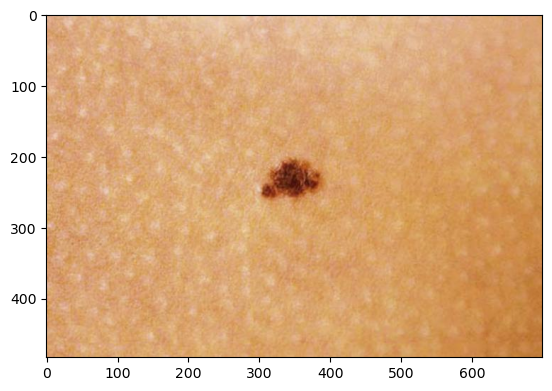

In [169]:
img = cv2.imread('benigntest3.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [170]:
resize = tf.image.resize(img, (256,256))

In [171]:
np.expand_dims(resize, 0)

array([[[[143.92245 , 181.59238 , 221.03574 ],
         [142.32726 , 176.7257  , 221.70703 ],
         [137.47707 , 170.47707 , 220.47707 ],
         ...,
         [121.75145 , 168.04152 , 222.04152 ],
         [109.21094 , 162.00781 , 215.80469 ],
         [105.      , 159.      , 214.      ]],

        [[146.41255 , 180.9948  , 221.89735 ],
         [139.59375 , 172.39519 , 218.59244 ],
         [140.2192  , 171.2192  , 222.2192  ],
         ...,
         [119.90341 , 167.22505 , 221.00586 ],
         [109.34245 , 162.13933 , 215.9362  ],
         [105.33008 , 159.33008 , 214.33008 ]],

        [[156.4048  , 187.44235 , 230.76317 ],
         [143.6289  , 173.94096 , 221.51997 ],
         [140.61606 , 171.68889 , 223.6487  ],
         ...,
         [117.05412 , 165.7832  , 219.11914 ],
         [108.6606  , 161.89107 , 215.68794 ],
         [104.2168  , 160.2168  , 215.2168  ]],

        ...,

        [[100.45363 , 147.45363 , 208.45363 ],
         [107.22461 , 154.22461 , 215.22461 ]

In [172]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [174]:
if yhat > 0.75:
    print('Predicted class is malignant.')
elif yhat < 0.50:
    print('Predicted class is benign.')
else:
    print('Predicted class is undetermined.')

Predicted class is benign.


# Save, Serialize, and Export the Model

In [175]:
# save the model
from tensorflow.keras.models import load_model

In [176]:
model.save(os.path.join('models', 'melanomamodel.h5'))

In [178]:
# loading in model
new_model = load_model(os.path.join('models','melanomamodel.h5'))

In [181]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.75:
    print('Predicted class is malignant.')
elif yhat < 0.50:
    print('Predicted class is benign.')
else:
    print('Predicted class is undetermined.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class is benign.
